<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_test_case_weather_multi_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Please see MFD: comments and "to do" comments

# Generate switching data set

In [31]:
p = 30 # the number of lags (in both the data and the models)
#vols=generate_vol_sample(1000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

#vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [32]:
uni_data = df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']] #['T (degC)']
uni_date = df['Date Time']
uni_data.index = uni_date
uni_data.head()
#uni_data = uni_data.values
#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_data_mean)/uni_train_std
#print(uni_data)
#df = pd.DataFrame(vols, columns=['vol'])

#plt.plot(uni_date,uni_data)






,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [0]:
#df = pd.DataFrame(vols, columns=['vol'])

# prepare data for RNNs

In [33]:
#features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
use_features = ['p (mbar)', 'T (degC)', 'rho (g/m**3)'] 
target = 'T (degC)'

n_steps = 20 # number of lags to include in the model

train_weight = 0.8
#split = int(len(df)*train_weight)
#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_train_mean)/uni_train_std
#print(uni_data)

df_new = df[:30000]
df_new[use_features].astype('float32').dtypes
#print(df_new[use_features])
split = int(len(df_new)*train_weight)

df_train = df_new[use_features].iloc[:split] 
df_train[use_features].astype('float32').dtypes
mu = df_train[use_features].mean()
sigma = df_train[use_features].std()
std_df_train = (df_train[use_features] - mu)/sigma
#.apply(lambda x: (x - mu) / sigma)
#print(std_df_train)
df_train = std_df_train 
#print(df_train[use_features])
#df_new = df[split:10000]
df_test = df_new[use_features].loc[split:]
#print(std_df_train)
std_df_test = (df_test[use_features].loc[split:] - mu)/sigma

#.apply(lambda x: (x-mu)/sigma).iloc[split:30000]
print("second df")
df_test = std_df_test
print(df_train)
print(df_test)
print("mu" + str(mu))
print("sigma" + str(sigma))


#train_weight = 0.8
#split = int(len(df)*train_weight)

#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_train_mean)/uni_train_std
#print(uni_data)

#df_train = df[use_features].iloc[:split]
#print(df_train)
#df_test = df[use_features].iloc[split:]

second df
       p (mbar)  T (degC)  rho (g/m**3)
0      0.865487 -1.743714      1.919380
1      0.870548 -1.792338      1.970351
2      0.866499 -1.804805      1.981291
3      0.864475 -1.779870      1.955184
4      0.864475 -1.774883      1.950460
...         ...       ...           ...
23995  0.642821  1.409356     -1.079424
23996  0.630675  1.383174     -1.055803
23997  0.627639  1.383174     -1.054560
23998  0.638772  1.390654     -1.059284
23999  0.659015  1.324576     -1.000855

[24000 rows x 3 columns]
       p (mbar)  T (degC)  rho (g/m**3)
24000  0.659015  1.258497     -0.949387
24001  0.656990  1.247276     -0.942176
24002  0.658002  1.234809     -0.933474
24003  0.666099  1.211120     -0.913832
24004  0.668124  1.184938     -0.892201
...         ...       ...           ...
29995  0.506184  1.188678     -0.948890
29996  0.512257  1.187432     -0.946403
29997  0.524402  1.194912     -0.947398
29998  0.532499  1.217354     -0.964305
29999  0.534524  1.241043     -0.984445

[60

In [0]:
#def get_lagged_features(value, n_steps):
#    lag_list = []
#    for lag in range(n_steps, 0, -1):
#        lag_list.append(value.shift(lag))
#    return pd.concat(lag_list, axis=1)

In [0]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [36]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(23971, 20, 3) (23971, 1, 1) (5971, 20, 3) (5971, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

time_size = y_train_reg.shape[1]


In [0]:
print(train_batch_size)

23971


# Define Alpha RNN models

In [0]:
tf.get_collection('alpha_t')

[]

In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.tanh(self.alpha)* output + 1-K.tanh(self.alpha)* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)

In [0]:
def AlphaRNNt(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model

In [0]:
def Alpha_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(AlphaRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model2

In [0]:
def Plain_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model2

In [0]:
def GRU_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
def LSTM_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNNt...")
model = KerasRegressor(build_fn=AlphaRNNt, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnnt = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
nodes_alpharnnt=10
l1_reg=0

In [0]:
alpharnnt = AlphaRNNt(nodes_alpharnnt,l1_reg)
alpharnnt.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

In [0]:
# serialize model to JSON
alpharnnt_json = alpharnnt.to_json()
with open("alpharnnt.json", "w") as json_file:
    json_file.write(alpharnnt_json)
# serialize weights to HDF5
alpharnnt.save_weights("alpharnnt.h5")
print("Saved model to disk")

TypeError: super(type, obj): obj must be an instance or subtype of type

In [55]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg,verbose=1)

5971/5971 [==============================] - 0s 32us/step


In [56]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnnt.summary()

3.7754402903910194
7.466683731604638
1.94304922490168
2.7325233268180233
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alphat_rnn_3 (AlphatRNN)     (None, 10)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNN...")
model = KerasRegressor(build_fn=Alpha_Rnn, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
#train optimized model
alpharnn = Alpha_Rnn(nodes_alpharnn,l1_reg)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es])

In [0]:
# serialize model to JSON
alpharnn_json = alpharnn.to_json()
with open("alpharnn.json", "w") as json_file:
    json_file.write(alpharnn_json)
# serialize weights to HDF5
alpharnn.save_weights("alpharnn.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg,verbose=1)

5971/5971 [==============================] - 1s 133us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnn.summary()

3.8313195413812458
4.566891653719235
1.9573756771200683
2.1370286974486876
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_2 (AlphaRNN)       (None, 10)                141       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for Plain RNN...")
model = KerasRegressor(build_fn=Plain_Rnn, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

In [0]:
rnn = Plain_Rnn(nodes,l1_reg)
rnn.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

In [0]:
# serialize model to JSON
rnn_json = rnn.to_json()
with open("rnn.json", "w") as json_file:
    json_file.write(rnn_json)
# serialize weights to HDF5
rnn.save_weights("rnn.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn.predict(x_test_reg, verbose=1)

5971/5971 [==============================] - 0s 54us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],rnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
rnn.summary()

3.802828692104928
4.832325513510811
1.9500842782056698
2.1982551065585656
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 45        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0,0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for GRU...")
model = KerasRegressor(build_fn=GRU_, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
l1_reg_gru = grid_result.best_params_['l1_reg']

In [0]:
gru = GRU_(nodes_gru,l1_reg_gru)
gru.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

In [0]:
# serialize model to JSON
gru_json = gru.to_json()
with open("gru.json", "w") as json_file:
    json_file.write(gru_json)
# serialize weights to HDF5
gru.save_weights("gru.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
gru_pred_train = gru.predict(x_train_reg, verbose=1)
gru_pred_test = gru.predict(x_test_reg, verbose=1)

5971/5971 [==============================] - 0s 36us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],gru_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],gru_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
gru.summary()

3.8355734528077967
4.536467825296365
1.9584620120920897
2.1298985481229766
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 10)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for LSTM...")
model = KerasRegressor(build_fn=LSTM_, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
l1_reg_lstm = grid_result.best_params_['l1_reg']

In [0]:
lstm = LSTM_(nodes_lstm,l1_reg_lstm)
lstm.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

In [0]:
# serialize model to JSON
lstm_json = lstm.to_json()
with open("lstm.json", "w") as json_file:
    json_file.write(lstm_json)
# serialize weights to HDF5
lstm.save_weights("lstm.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm.predict(x_test_reg, verbose=1)

5971/5971 [==============================] - 0s 48us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],lstm_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],lstm_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
lstm.summary()

3.833120729945927
4.582777042589019
1.9578357259856933
2.1407421709745944
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                560       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [0]:
use_feature=target

NameError: ignored

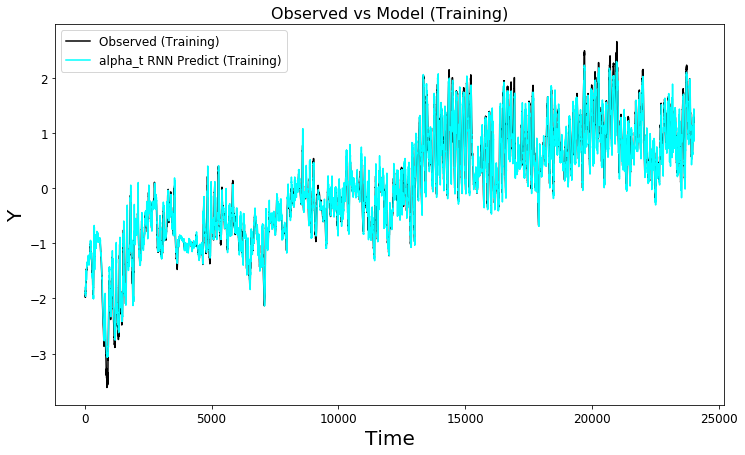

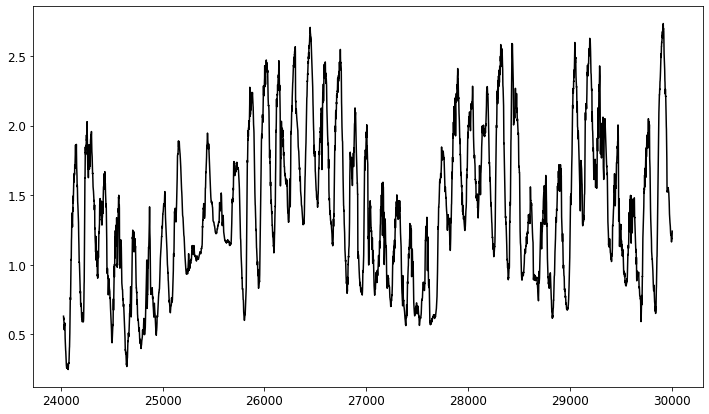

In [61]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], df_train[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
#train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_train[:,0], color="cyan", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], df_test[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], lstm_pred_test[:, 0], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], gru_pred_test[:, 0], color="orange", label="GRU Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], alpharnn_pred_test,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_test, color="cyan", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

## Training

In [0]:
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reserved for the second term
input_dimensions = 1

# Arbitrary number for the size of the hidden state
hidden_size = 10 #<= MFD: vary this between 1,2,5,10,20


In [0]:
#l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

#regularized_loss = total_loss + regularization_penalty

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]
batch_size  = 100
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = alphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size =int(batch_size/n_splits))
  val_loss+=val_loss_
 val_losses.append(val_loss)

In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

In [0]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses2=[]
batch_size  = int(100/n_splits)
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn, x_train, x_test, y_train, y_test, max_epochs, batch_size)
  val_loss+=val_loss_
 val_losses2.append(val_loss)

In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses2))
print(hidden_sizes[idx])

In [0]:
session = tf.Session()
alpharnn = SimpleAlphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:
#session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
#W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
#b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

#output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 


#model,_=train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

       

In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]

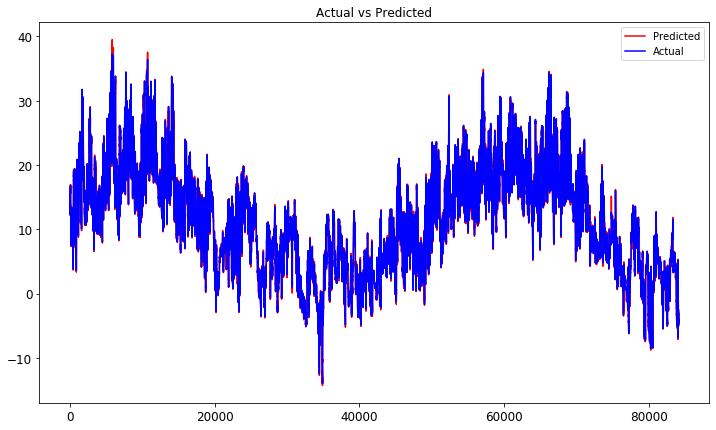

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()


## Cross-Validation

In [0]:
# Create a new instance of the alpha_RNN model
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)

alpharnn_cv = alphaRNN(input_dimensions, hidden_size)

In [0]:
# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) #prediction

In [0]:
def cross_validate(session, split_size):

  results = []

  tscv = TimeSeriesSplit(split_size)
    
  """
  The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) 
  in the i``th split, with a test set of size ``n_samples//(n_splits + 1), 
  where n_samples is the number of samples.
  
  """

  for train_idx, val_idx in tscv.split(x_train_reg):
    print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)
    expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_reg[train_idx]
    train_y = y_train_reg[train_idx]

    val_x = x_train_reg[val_idx]
    val_y = y_train_reg[val_idx]
    
    train(alpharnn, train_x, val_x, train_y, val_y)
    val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    results.append(session.run(val_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y}))

  return results


In [0]:
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  #result = cross_validate(session, 5)
  #print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn.input_layer: x_test_reg, expected_output_test: y_test_reg}))

NameError: ignored

In [0]:
session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
alpharnn_t = alphaRNN(input_dimensions, hidden_size)
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn_t.h_t) 

train(alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


Epoch  0 / 200 :  	Training Loss: 21.43568 	Validation Loss: 37.10702
Epoch  50 / 200 :  	Training Loss: 3.98413 	Validation Loss: 4.01063
Epoch  100 / 200 :  	Training Loss: 4.01077 	Validation Loss: 4.08058
Epoch  150 / 200 :  	Training Loss: 3.95643 	Validation Loss: 3.97600


KeyboardInterrupt: ignored

In [0]:
#train_loss = 0
#expected_output_test = 0
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  result = cross_validate(session, 5)
  print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn_t.input_layer: x_test_reg, expected_output_test: y_test_reg}))

In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]


In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_train_reg})
y_predicted_ar_train_t=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
print(train_losses[0][1])

## Diagnostics (visualize fitted values)

In [0]:

# MFD: It would be good to visualize the amount of smoothing, but I get an error
#alpha=session.run(alpharnn.alpha, feed_dict={alpharnn.input_layer: x_test_reg})

In [0]:
#plt.plot(alpha_t[:,n_steps-1,1], 'red')
#pplt.plot(y_test_reg.flatten(),'blue')

# Comparsion with Keras GRU, RNN, LSTM

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)
 
 

MFD: batch size must match that used for alpha_RNN when comparing LSTM



In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model


In [0]:
n_units = [1,2,5,10,20,50]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']


Hyper parameter tuning for RNN...


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
hidden_size = nodes
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

In [0]:
# predict out of sample
hidden_size = nodes # optimal number of nodes
rnn_model = RNN_model2(hidden_size,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

In [0]:
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for  GRU...")
model = KerasRegressor(build_fn=GRU_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']

In [0]:
hidden_size_gru = nodes_gru
gru_model = Sequential()
gru_model.add(GRU(hidden_size_gru, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

In [0]:
gru_model = GRU_model2(hidden_size_gru,l1_reg)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

In [0]:
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for LSTM...")
model = KerasRegressor(build_fn=LSTM_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']

In [0]:
hidden_size_lstm = nodes_lstm
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size_lstm, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=30000, callbacks=[es])

In [0]:
# predict ouf of sample
lstm_model = LSTM_model2(hidden_size,l1_reg)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()


In [0]:
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)

#print("Hyper parameter tuning for GRU...")        
#model = KerasRegressor(build_fn=GRU_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result2 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#means = grid_result2.cv_results_['mean_test_score']
#stds = grid_result2.cv_results_['std_test_score']
#params = grid_result2.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
        
#print("Hyper parameter tuning for LSTM...")
#model = KerasRegressor(build_fn=LSTM_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result3 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#means = grid_result3.cv_results_['mean_test_score']
#stds = grid_result3.cv_results_['std_test_score']
#params = grid_result3.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))       
                
#nodes = 10# grid_result.best_params_['n_units']
#epochs_rnn = grid_result.best_params_['epochs']
#l1_reg = grid_result.best_params_['l1_reg']
#batch_size_rnn = grid_result.best_params_['batch_size']

#nodes_gru = grid_result2.best_params_['nodes']
#epochs_gru = grid_result2.best_params_['epochs']
#l1_reg_gru = grid_result2.best_params_['l1_reg']
#batch_size_gru = grid_result2.best_params_['batch_size']

#nodes_lstm = grid_result3.best_params_['nodes']
#epochs_lstm = grid_result3.best_params_['epochs']
#l1_reg_lstm = grid_result3.best_params_['l1_reg']
#batch_size_lstm = grid_result3.best_params_['batch_size']
#print("Hyper parameter tuning for RNN...")
#model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV

#nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0
#TimeSeriesSplit(max_train_size=None, n_splits=10)
#tscv = TimeSeriesSplit()
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    rnn_model = RNN_model2(nodes,l1_reg)
   
#    rnn_fit = rnn_model.fit(x_train,y_train, epochs=500, batch_size=100, callbacks=[es])
#    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
#    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#rnn_model.summary()
#MSE_train_ave = MSE_train/n_splits
#MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_ave = MSE_test/n_splits
#MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_rnn_ave = " + str(MSE_train_ave))
#print("MSE_test_rnn_ave = " + str(MSE_test_ave))
#print("MSE_train_rnn_std = " + str(MSE_train_std))
#print("MSE_test_rnn_std = " + str(MSE_test_std))
#print("p = " + str(p))

#rnn_model = RNN_model2(nodes,l1_reg)
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
#rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
#print("RNN test data mse = " + str(mse))
#print("RNN test std mse = " + str(np.sqrt(mse)))
#rnn_model.summary()



#lstm_model = Sequential()
#lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#lstm_model.add(Dense(1))
#lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

In [0]:
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)

#print("Hyper parameter tuning for GRU...")        
#model = KerasRegressor(build_fn=GRU_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result2 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#means = grid_result2.cv_results_['mean_test_score']
#stds = grid_result2.cv_results_['std_test_score']
#params = grid_result2.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#       print("%f (%f) with %r" % (mean, stdev, param))
        
#print("Hyper parameter tuning for LSTM...")
#model = KerasRegressor(build_fn=LSTM_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result3 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#means = grid_result3.cv_results_['mean_test_score']
#stds = grid_result3.cv_results_['std_test_score']
#params = grid_result3.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))       
                
#nodes = 10# grid_result.best_params_['n_units']
#epochs_rnn = grid_result.best_params_['epochs']
#l1_reg = grid_result.best_params_['l1_reg']
#batch_size_rnn = grid_result.best_params_['batch_size']

#nodes_gru = grid_result2.best_params_['nodes']
#epochs_gru = grid_result2.best_params_['epochs']
#l1_reg_gru = grid_result2.best_params_['l1_reg']
#batch_size_gru = grid_result2.best_params_['batch_size']

#nodes_lstm = grid_result3.best_params_['nodes']
#epochs_lstm = grid_result3.best_params_['epochs']
#l1_reg_lstm = grid_result3.best_params_['l1_reg']
#batch_size_lstm = grid_result3.best_params_['batch_size']
#print("Hyper parameter tuning for RNN...")
#model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV

#nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0
#TimeSeriesSplit(max_train_size=None, n_splits=10)
#tscv = TimeSeriesSplit()
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    rnn_model = RNN_model2(nodes,l1_reg)
   
#    rnn_fit = rnn_model.fit(x_train,y_train, epochs=500, batch_size=100, callbacks=[es])
#    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
#    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#rnn_model.summary()
#MSE_train_ave = MSE_train/n_splits
#MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_ave = MSE_test/n_splits
#MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_rnn_ave = " + str(MSE_train_ave))
#print("MSE_test_rnn_ave = " + str(MSE_test_ave))
#print("MSE_train_rnn_std = " + str(MSE_train_std))
#print("MSE_test_rnn_std = " + str(MSE_test_std))
#print("p = " + str(p))

#rnn_model = RNN_model2(nodes,l1_reg)
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
#rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
#print("RNN test data mse = " + str(mse))
#print("RNN test std mse = " + str(np.sqrt(mse)))
#rnn_model.summary()



#lstm_model = Sequential()
#lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#lstm_model.add(Dense(1))
#lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

### LSTM


### RNN

### GRU

### Prediction

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 3s 40us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 2s 26us/step


In [0]:
# compare with the trained plain GRU

In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 3s 39us/step


### Model Performance

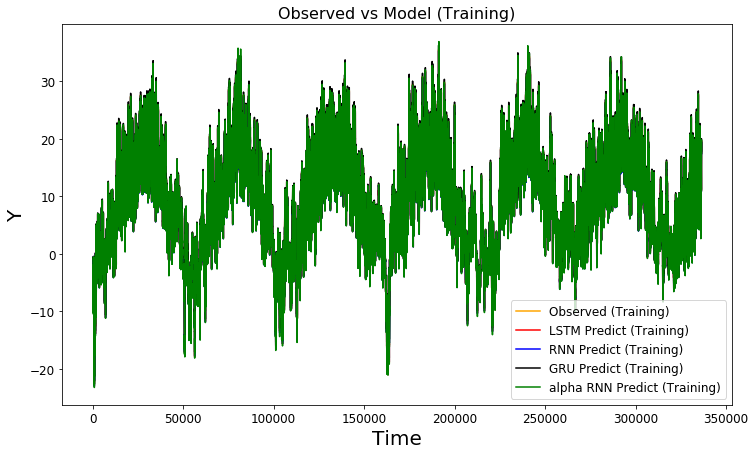

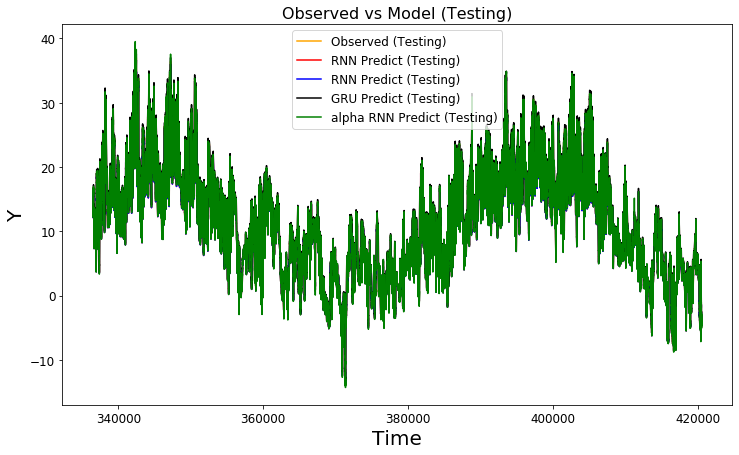

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train_t, color="yellow", label="alpha_t RNN Predict (Training)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar_t, color="yellow",label="alpha_t RNN Predict (Testing)"
test_line_pred = plt.plot(y_predicted_ar_t, color="yellow", label="alpha_t RNN Predict (Testing)")

# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

In [0]:
# calculate mean squared error of the plain LSTM
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], lstm_pred_test[:, 0])
print(MSE_test)

NameError: ignored

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:],y_prediction_train) # train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_prediction_ar) # validation_losses[:, 0])
print(MSE_test)

In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:],y_prediction_train) # train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_prediction_ar) # validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)